In [2]:
import tensorflow as tf
import numpy as np
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [63]:
def read_image_tfds(image, label):
  xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
  ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)
  image = tf.reshape(image, (28, 28, 1))
  image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
  image = tf.cast(image, tf.float32) / 255.0
  xmin = tf.cast(xmin, tf.float32)
  ymin = tf.cast(ymin, tf.float32)
  xmax = (xmin + 28) / 75
  ymax = (ymin + 28) / 75
  xmin /= 75
  ymin /= 75

  return image, (tf.one_hot(label, 10)), [xmin, ymin, xmax, ymax]

In [66]:
BATCH_SIZE = 64
train = tfds.load('mnist', split="train", as_supervised=True)
train_dataset = train.map(read_image_tfds, num_parallel_calls=16).shuffle(1024, reshuffle_each_iteration=True).batch(64).prefetch(tf.data.AUTOTUNE)

valid = tfds.load('mnist', split='test', as_supervised=True)
valid_dataset = valid.map(read_image_tfds, num_parallel_calls=16).batch(BATCH_SIZE)

In [67]:
img = next(iter(train_dataset))[0]

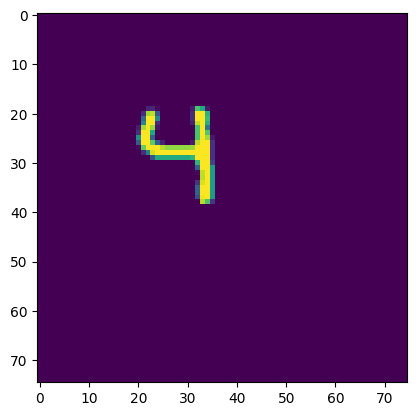

In [69]:
plt.imshow(img[0])